In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit, differential_evolution
from scipy.stats import skew

import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (12,7)
sns.set()

---
## Create fake data; for this example, we'll use:
<ul>
    <li>between-well spacing,
    <li>completion fluid volume, and 
    <li>completion sand volume.
</ul>

---

In [2]:
# add several fake well packages at various spacings:
spacing = np.concatenate([np.repeat(440, 12), 
                          np.repeat(660, 8),
                          np.repeat(880, 6), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)])

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .1, len(spacing))

spacing

array([ 482.11720014,  425.26752929,  377.20624241,  409.46934566,
        347.61837243,  390.07927781,  447.75885646,  335.49462681,
        498.92775188,  440.90012531,  500.23673652,  473.28295948,
        722.3909876 ,  747.29573732,  735.68689124,  543.21955376,
        619.29972735,  691.76168958,  752.54504097,  683.42225246,
        800.85790636,  890.81177727,  789.71840143,  791.5834038 ,
       1016.96407205,  848.97545883, 1130.73446342, 1261.35644333,
       1142.84038326, 1037.30195451, 1223.14151891, 1010.10887208,
        901.26575227, 1078.5611164 ,  740.90567219, 1177.12060377,
       1479.1134947 , 1424.69617391, 1496.89523887, 1280.6785234 ,
       1197.81125365, 1422.48051341, 1482.61693348, 1088.2199004 ,
       2293.08206459])

In [3]:
# create a dafatframe:
df = pd.DataFrame({'spacing': spacing})

# ensure data type 'float' for spacing:
df['spacing'] = df['spacing'].astype('float')

# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.concatenate([np.repeat(45,6), np.repeat(33, 6), np.repeat(43, 8), np.repeat(42, 4), np.repeat(70, 2), 
               np.repeat(62, 3), np.repeat(45, 4), np.repeat(35, 3), np.repeat(45, 9)])

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, len(df))

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3:2 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], len(df))

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have a problematic collinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft
0,482.117200,45.928150,40,1837.125986
1,425.267529,43.911597,30,1317.347920
2,377.206242,45.738824,40,1829.552974
3,409.469346,46.297317,30,1388.919510
4,347.618372,43.916022,40,1756.640869
5,390.079278,43.877234,40,1755.089367
6,447.758856,33.385676,30,1001.570292
7,335.494627,31.021658,40,1240.866333
8,498.927752,34.154519,40,1366.180755
9,440.900125,34.482108,40,1379.284307


## Define a function for the initial population of fake well EURs, define a related cost function, and set related parameters.
### Utilize a modified sigmoid function, where
<ul>
    <li>L is the horizontal asymptote - the EUR for true stand-alone wells
    <li>k is the exponential factor - typically very small (k << 0.1)
    <li>b0 is the vertical axis intercept - the EUR two wells occupying the same position (zero spacing) would recover

In [4]:
k = 0.0025
L = 120
b0 = 60

# population function
# this is out underlying (synthetic) EUR/ft relationship
def mod_sig(spacing, k, L, b0):
    return L / (1 + np.exp(-k * (spacing - 0))) - L/2 + b0

# We expect error in EUR/ft to be lognormally distributed for a given state of
# the determinants we examine. So we define a cost function that allows the curve_fit
# algorithm to measure error against the log of EUR/ft, while still allowing us to 
# choose constraints for the algorithm which fit our intuitive understanding (linear
# space) of the reservoir & the data.

def cost(spacing, k, L, b0):
    return np.log(mod_sig(spacing, k, L, b0))

### Populate the fake EUR data & add noise

In [21]:
# adjust the EUR/ft by 8% for 25% change in sand concentration:
sd_conc_factor = 0.05 / .25

# adjust the EUR/ft by 20% for every 25% change in compl fluid per ft:
fluid_pft_factor = 0.1 / .25

df['eur_per_ft'] = df.apply(lambda x: mod_sig(x['spacing'], k, L, b0), axis=1)
df['eur_per_ft'] = (1 + ((df['compl_sd_conc'] - 40) / 40) * (sd_conc_factor)) * df['eur_per_ft']
df['eur_per_ft'] = (1 + ((df['compl_bbl_per_ft'] - 45) / 45) * (fluid_pft_factor)) * df['eur_per_ft']

eur_noise = np.random.lognormal(sigma=np.std(df['eur_per_ft']) / 20, size=len(df))

df['eur_per_ft'] = df['eur_per_ft'] + eur_noise

df = df.sort_values('spacing')

df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eur_per_ft
7,335.494627,31.021658,40,1240.866333,73.911304
4,347.618372,43.916022,40,1756.640869,84.432816
2,377.206242,45.738824,40,1829.552974,89.118492
5,390.079278,43.877234,40,1755.089367,87.063474
3,409.469346,46.297317,30,1388.919510,86.036847
1,425.267529,43.911597,30,1317.347920,84.815738
9,440.900125,34.482108,40,1379.284307,82.643814
6,447.758856,33.385676,30,1001.570292,81.905153
11,473.282959,33.866693,40,1354.667728,87.462289
0,482.117200,45.928150,40,1837.125986,94.759846


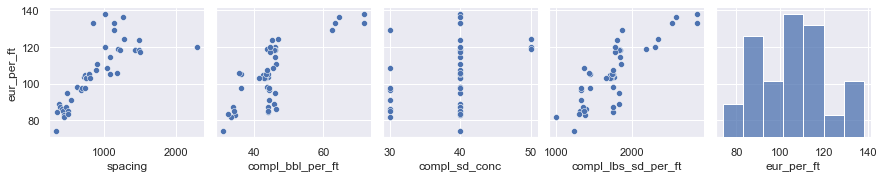

In [22]:
sns.pairplot(df, y_vars='eur_per_ft')

fit: k: 0.00242 
     L: 159.71 
     b0: 47.33


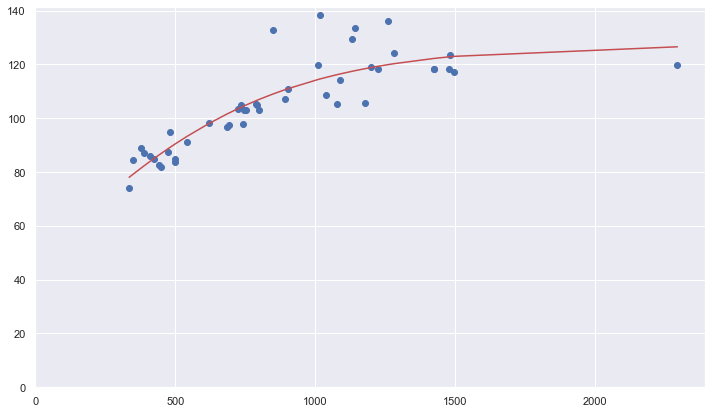

In [30]:
y = np.array(df['eur_per_ft'].values)
x = df['spacing'].values

# fit to linear-space error:
# popt, _ = curve_fit(mod_sig, x, y, bounds=([0, 70, 0], [.1, 200, 100]))

# or fit to log-space error:
popt, _ = curve_fit(cost, x, np.log(y), bounds=([0, 70, 0], [.1, 200, 100]))


# result = differential_evolution(cost(df['spacing'], L, k, b0), bounds=[(0,.1), (70, 200), (0, 100)])

plt.scatter(x=x, y=y)
plt.plot(x, mod_sig(x, *popt), color='r')

plt.xlim(0,)
plt.ylim(0,)

print('fit: k: %1.5f \n     L: %1.2f \n     b0: %1.2f' % tuple(popt))

In [36]:
err = y - mod_sig(x, *popt)

1.4434139169089952


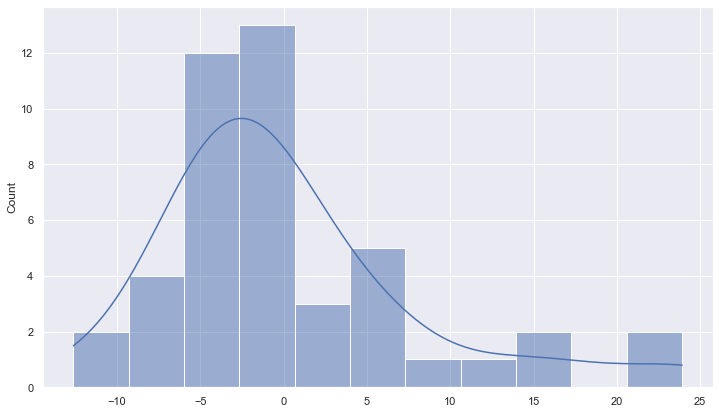

In [37]:
sns.histplot(err, kde=True)

print(skew(err))

1.2204553654259744


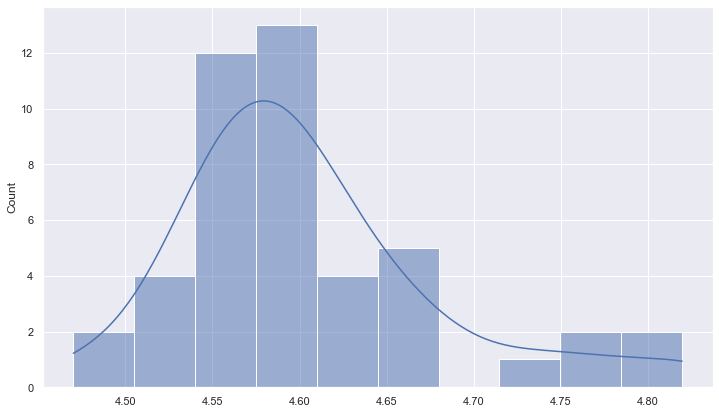

In [38]:
trans_err = np.log(err + 100)

sns.histplot(trans_err, kde=True)
print(skew(trans_err))

In [43]:
dfols = df[['compl_bbl_per_ft', 'compl_sd_conc']]
dfols['trans_err'] = trans_err
dfols

c:\envs\base\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,compl_bbl_per_ft,compl_sd_conc,trans_err
7,31.021658,40,4.562943
4,43.916022,40,4.657717
2,45.738824,40,4.679440
5,43.877234,40,4.650575
3,46.297317,30,4.626187
1,43.911597,30,4.602250
9,34.482108,40,4.568255
6,33.385676,30,4.555292
11,33.866693,40,4.593678
0,45.928150,40,4.659028


In [47]:
Xols = sm.add_constant(dfols.drop('trans_err', axis=1))
yols = dfols['trans_err']

In [48]:
ols = sm.OLS(yols, Xols)
ols_result = ols.fit()

In [49]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              trans_err   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     65.34
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           1.28e-13
Time:                        23:27:26   Log-Likelihood:                 85.337
No. Observations:                  45   AIC:                            -164.7
Df Residuals:                      42   BIC:                            -159.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.2042      0.054     77.862      0.000       4.095       4.313
compl_bbl_per_ft     0.0071      0.001     11.316      0.000       0.006       0.008
compl_sd_conc        0.0021      0.001      1.786      0.081      -0.000       0.004
==============================================================================
Omnibus:                        0.975   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.910
Skew:                          -0.135   Prob(JB):                        0.634
Kurtosis:                       2.358   Cond. No.                         578.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
trial_fluid_load = 45
trial_sd_conc = 40
trial_spacing = 880

def predict_eur(spacing, fluid_load, sd_conc):
    return (mod_sig(spacing, *popt) + np.exp(ols_result.predict([1,fluid_load, sd_conc])) - 100)[0]

In [86]:
df['model_eur'] = df.apply(lambda x: predict_eur(x['spacing'], x['compl_bbl_per_ft'], x['compl_sd_conc']), axis=1)
df

,spacing,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eur_per_ft,model_eur
7,335.494627,31.021658,40,1240.866333,73.911304,68.776956
4,347.618372,43.916022,40,1756.640869,84.432816,78.480075
2,377.206242,45.738824,40,1829.552974,89.118492,82.148422
5,390.079278,43.877234,40,1755.089367,87.063474,81.833313
3,409.469346,46.297317,30,1388.919510,86.036847,82.973315
1,425.267529,43.911597,30,1317.347920,84.815738,82.501457
9,440.900125,34.482108,40,1379.284307,82.643814,79.258953
6,447.758856,33.385676,30,1001.570292,81.905153,77.141759
11,473.282959,33.866693,40,1354.667728,87.462289,81.189770
0,482.117200,45.928150,40,1837.125986,94.759846,90.101714
